# Imports

In [349]:
#misc
import logging
import os
import pprint
logging.basicConfig(level=logging.INFO)

import multiprocessing
print("cores", multiprocessing.cpu_count())
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# http
import requests
import json
from datetime import datetime, date, timedelta
import time
from bs4 import BeautifulSoup


# data viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# data
import numpy as np
#import dask.dataframe as pd
import pandas as pd
import pickle
from collections import defaultdict
import re
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)
from copy import deepcopy

#nlp
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
from sense2vec import Sense2VecComponent
from spacy import displacy
from tqdm import tqdm_notebook as tqdm


import gensim
import gensim.corpora as corpora
from gensim import matutils
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser

import pyLDAvis.gensim
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation


# Constants
RANDOM_STATE=42
SAMPLE_SIZE=2000
WORKERS=3

cores 8


# Read saved sample

In [222]:
#df_sample = df_full.head(20000).sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
df_sample = pd.read_pickle('./reddit_df_19_sub.pkl')

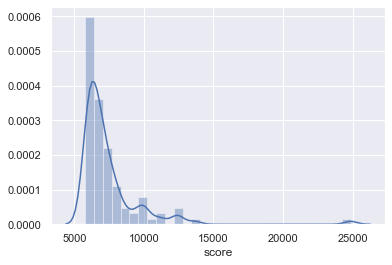

In [223]:
sns.distplot(df_sample['score'])

# Preprocess

## get text column

In [249]:
docs_a = df_sample['selftext']
docs_a.describe()

count     100                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

## Stopwords
(Notes as I spot them)
- trigger warning: <trigger type>
- [part %d]
- voting thread
- mods
- http.*
- sub
- post
- reddit

## Pipeline

In [250]:
# def remove_markdown(doc):
    
#     text = BeautifulSoup(' '.join(doc)).text
#     return nlp.make_doc(text)

# def remove_special_chars(doc):
#     text = BeautifulSoup(' '.join(doc)).text
#     return nlp.make_doc(text)

def lowercase(doc):
    doc = [token.lower_ for token in doc]
    doc = ' '.join(doc)
    return nlp.make_doc(doc)

def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc]
    doc = ' '.join(doc)
    return nlp.make_doc(doc)

def filter_doc(doc):
    doc = [token.text for token in doc 
           if token.is_space != True
           and token.like_url != True 
           and token.like_email != True 
           and token.is_punct != True 
          ] 
    doc = ' '.join(doc)
    return nlp.make_doc(doc)

def norm(doc):
    doc = [token.norm_ for token in doc] 
    doc = ' '.join(doc)
    return nlp.make_doc(doc)

def remove_pronouns(doc):
    # This will remove stopwords and punctuation and whitespace.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.lemma_ != '-PRON-'] 
    doc = ' '.join(doc)
    return nlp.make_doc(doc)

def remove_stopwords(doc):
    # This will remove stopwords and punctuation and whitespace.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if not token.is_stop] 
    doc = ' '.join(doc)
    return nlp.make_doc(doc)

In [246]:
nlp = spacy.load('en_core_web_md')

stop_words = list(pd.read_csv('news-stopwords/sw10k.csv')['term'])
stop_words.extend([
    'know', 'like', 'look', 'nosleep', 'reddit', 'post', '’s', "\'s", "'s", 
])

# Updates spaCy's default stop words list with my additional words. 
nlp.Defaults.stop_words.update(stop_words)
# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True
    

#merge_ents = nlp.create_pipe("merge_entities")
#nlp.add_pipe(merge_ents,after='lemmatizer')    
#merge_nps = nlp.create_pipe("merge_noun_chunks")
#nlp.add_pipe(merge_nps, after='parser')
# s2v = Sense2VecComponent(nlp.vocab).from_disk("/Users/kirill.kogan/Documents/data/models/sense2vec-vectors/")
# nlp.add_pipe(s2v)    
    
#nlp.add_pipe(remove_markdown, name='remove_markdown', first=True)
#nlp.add_pipe(lemmatizer, name='lemmatizer', before='ner')
nlp.add_pipe(filter_doc, name='filter_doc', after='ner')
nlp.add_pipe(lowercase, name='lowercase', after='filter_doc')
nlp.add_pipe(norm, name="norm", after='lowercase')
nlp.add_pipe(remove_stopwords, name="remove_stopwords", after='norm')


//anaconda3/envs/reddit/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
//anaconda3/envs/reddit/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
//anaconda3/envs/reddit/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
//anaconda3/envs/reddit/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
//anaconda3/envs/reddit/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
//anaconda3/envs/reddit/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecate

In [247]:
nlp.vocab['not'].is_stop

True

## Run Pipe

In [182]:
print(nlp.pipe_names)

['tagger', 'parser', 'ner', 'filter_doc', 'lowercase', 'remove_stopwords', 'norm']


In [183]:
test_doc = docs_a.iloc[0]

In [163]:
displacy.render(nlp(test_doc), style="ent", jupyter=True)

//anaconda3/envs/reddit/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


In [184]:
doc_list = []
# Iterates through each article in the corpus.
for doc in  nlp.pipe(tqdm(docs_a), batch_size=10, n_threads=WORKERS):
    #text = [token.text for token in doc]
    doc_list.append([token.text for token in doc])


//anaconda3/envs/reddit/lib/python3.7/site-packages/tqdm/__init__.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  TqdmDeprecationWarning)


In [198]:
doc = nlp(test_doc)
print([token.text for token in doc if not token.is_stop])

['tinder', 'thirties', '$', 'swiped', 'tinder', 'sweetheart', 'cringed', 'hated', 'sucked', 'specified', 'venmo', 'stared', '$', 'clicked', 'stared', 'favors', 'naive', 'tinder', 'kik', 'kik', 'texted', 'omw', 'buzzed', 'driveway', 'sore', 'thumb', 'nicer', 'shit', 'doorway', 'skimming', 'muscles', 'torso', 'tattoos', 'uh', 'gripped', 'cardboard', 'shoebox', 'stained', 'damp', 'trunk', 'alright', 'drown', 'driveway', 'admiring', 'pillars', 'porch', 'greenest', 'locking', 'overboard', 'stared', 'cushioned', 'maroon', 'admired', 'furnish', 'ringing', 'froze', 'buzzed', 'marvin', 'poking', 'caller', 'creeped', 'remembering', 'favors', 'briefcase', 'julio', '$', '3500', 'proceeded', '$', 'driveway', 'porch', 'unlocked', 'wandered', 'marvin', 'faucets', 'anyone-', 'are-', 'closet', 'gardener', 'fridge', 'goodnight', 'regretting', 'haunted', 'lounged', 'shit', '8:50', 'brushed', 'faucet', 'closet', 'hallway', 'couch', 'couch', 'scrolling', 'peculiar', 'dozed', '10:16', 'woken', 'doorbell', '

## Phrases

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(4024 unique tokens: ['$', '10:16', '3500', '8:50', 'admired']...) from 50 documents (total 10208 corpus positions)


In [200]:
# Turns each document into a bag of words.
words = corpora.Dictionary(doc_list)
corpus = [words.doc2bow(doc) for doc in doc_list]

In [201]:
pprint.pprint(words)

### Title column

# Topics

In [ ]:
# make binary count vectorizer X NMF
# make count vectorizer X NMF
# make tfidf vectorizer X NMF

# make binary count vectorizer X LDA
# make count vectorizer X LDA
# make tfidf vectorizer X LDA

# make binary count vectorizer X COREX
# make count vectorizer X COREX
# make tfidf vectorizer X COREX


# look into BERT
# 

## Topic Text Params

## Topic Modeling

### Latent Semantic Analysis
Acronynms: Latent Semantic Analysis (LSA) is just another name for 
Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)

In [202]:
docs_list_joined = [' '.join(words) for words in doc_list]

In [203]:
docs_list_joined[0]

'tinder thirties $ swiped tinder sweetheart cringed hated sucked specified venmo stared $ not clicked not stared am favors not naive will would tinder kik kik texted am omw buzzed driveway am sore thumb nicer shit doorway skimming muscles torso tattoos uh not gripped cardboard shoebox stained damp trunk alright not drown not driveway admiring pillars porch greenest locking overboard stared cushioned maroon admired furnish ringing froze buzzed not not marvin poking caller creeped not remembering have favors briefcase julio have $ 3500 not proceeded $ driveway porch unlocked wandered marvin not faucets not anyone- are- closet gardener fridge will goodnight regretting would haunted lounged shit 8:50 brushed faucet closet hallway couch couch scrolling not peculiar dozed 10:16 woken doorbell ringing not anyone- are- couch paranoid slightest not are not heartbeat doorbell not not doorbell not asleep gardener unlocked peered stove stirring brewed not scrambled motioning spoon drank freaky awk

In [376]:
def display_topics(model, feature_names, no_top_words=10, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [379]:
def hyperparameter_topics(docs_list, vectorizer='count', num_topic=10,
                          binary=False, max_df=0.08, min_df=1, stop_words = 'english',
                         model='lda'):
    vec = None
    if vectorizer == 'count':
        vec = CountVectorizer(stop_words=stop_words, binary=binary, max_df=max_df, min_df=min_df)
#         tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
#                                 stop_words = 'english',
#                                 lowercase = True,
#                                 token_pattern = r'\b[a-zA-Z]{3,}\b',
#                                 max_df = 0.5, 
#                                 min_df = 10)
    elif vectorizer == 'tfidf':
        vec = TfidfVectorizer(stop_words=stop_words, binary=binary, max_df=max_df, min_df=min_df)
        
        
    doc_word_matrix = vec.fit_transform(docs_list)
    feature_names = vec.get_feature_names()
    
    doc_topic = None
    mod = None
    if model == 'lda':
        # Convert sparse matrix of counts to a gensim corpus
        corpus = matutils.Sparse2Corpus(doc_word_matrix.transpose())
        # We need to save a mapping (dict) of row id to word (token) for later use by gensim:
        id2word = dict((v, k) for k, v in vec.vocabulary_.items())
        mod = LatentDirichletAllocation(n_components=num_topic)
        mod.fit(doc_word_matrix)
        
        #pprint.pprint(mod.print_topics(num_words=20))

    elif model == 'lsa':
        mod = TruncatedSVD(num_topic)
        doc_topic = mod.fit_transform(doc_word_matrix)
        print('explained_variance_ratio_', lsa.explained_variance_ratio_)
        display_topics(mod, feature_names)
    elif model == 'nmf':
        mod = NMF(num_topic)
        doc_topic = mod.fit_transform(doc_word_matrix)
        display_topics(mod, feature_names)
        
    return (mod, vec, feature_names, doc_word_matrix)

In [382]:
model, vec, feature_names, doc_words_matrix = hyperparameter_topics(docs_list_joined, 
                                                                         vectorizer='tfidf', 
                                                                         binary=False, 
                                                                         max_df=0.08, 
                                                                         min_df=1, 
                                                                         stop_words = 'english',
                                                                         model='lda',
                                                                         num_topic=5
                                                                        )


In [383]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
#pyLDAvis.sklearn.prepare(model, corpus, words)
#https://github.com/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

pyLDAvis.sklearn.prepare(model, doc_words_matrix, vec)

//anaconda3/envs/reddit/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.003925 -0.004653  1       1        27.019011
3     -0.002649  0.005659  2       1        22.612600
4      0.006349 -0.000488  3       1        20.720904
1      0.000727 -0.000353  4       1        17.645399
2     -0.000501 -0.000165  5       1        12.002085, topic_info=     Category      Freq             Term     Total  loglift  logprob
191   Default  0.000000  attendant        0.000000  30.0000  30.0000
192   Default  0.000000  attendants       0.000000  29.0000  29.0000
3819  Default  0.000000  ya               0.000000  28.0000  28.0000
2184  Default  0.000000  myron            0.000000  27.0000  27.0000
2451  Default  0.000000  pine             0.000000  26.0000  26.0000
3769  Default  0.000000  whistling        0.000000  25.0000  25.0000
2231  Default  0.000000  nirali           0.000000  24.0000  24.0000
3043  Default  0.000000  sledgehammer     0.000000  23.0000  23.0000
1988  Default  0.000000  lyla             0.000000  22.0000  22.0000
137   Default  0.000000  annie            0.000000  21.0000  21.0000
2567  Default  0.000000  prue             0.000000  20.0000  20.0000
1458  Default  0.000000  grandad          0.000000  19.0000  19.0000
92    Default  0.000000  airpods          0.000000  18.0000  18.0000
2112  Default  0.000000  molyneaux        0.000000  17.0000  17.0000
3732  Default  0.000000  webcam           0.000000  16.0000  16.0000
202   Default  0.000000  avi              0.000000  15.0000  15.0000
2897  Default  0.000000  scritt           0.000000  14.0000  14.0000
2154  Default  0.000000  mouse            0.000000  13.0000  13.0000
1     Default  0.000000  03               0.000000  12.0000  12.0000
2111  Default  0.000000  molly            0.000000  11.0000  11.0000
3749  Default  0.000000  whack            0.000000  10.0000  10.0000
1805  Default  0.000000  janelle          0.000000  9.0000   9.0000 
1119  Default  0.000000  envelope         0.000000  8.0000   8.0000 
1807  Default  0.000000  jar              0.000000  7.0000   7.0000 
1781  Default  0.000000  invisible        0.000000  6.0000   6.0000 
229   Default  0.000000  balcony          0.000000  5.0000   5.0000 
1953  Default  0.000000  liza             0.000000  4.0000   4.0000 
2050  Default  0.000000  melanie          0.000000  3.0000   3.0000 
3532  Default  0.000000  tunnels          0.000000  2.0000   2.0000 
2404  Default  0.000000  peeping          0.000000  1.0000   1.0000 
1458  Topic1   0.129528  grandad          0.195399  0.8975  -6.6740 
1805  Topic1   0.112284  janelle          0.178153  0.8470  -6.8169 
1807  Topic1   0.115628  jar              0.187536  0.8250  -6.7876 
1003  Topic1   0.097177  dorothy          0.163047  0.7911  -6.9614 
2050  Topic1   0.119922  melanie          0.211471  0.7414  -6.7511 
767   Topic1   0.080837  crate            0.146706  0.7126  -7.1455 
1993  Topic1   0.079556  magician         0.148037  0.6876  -7.1615 
115   Topic1   0.073501  ambien           0.139370  0.6688  -7.2406 
895   Topic1   0.069542  derwin           0.135412  0.6422  -7.2960 
1462  Topic1   0.068399  grandparents     0.134268  0.6341  -7.3126 
599   Topic1   0.066641  circus           0.132510  0.6213  -7.3386 
3662  Topic1   0.061377  vents            0.127247  0.5795  -7.4209 
738   Topic1   0.060909  cottage          0.126781  0.5755  -7.4286 
1082  Topic1   0.075680  elevator         0.158808  0.5675  -7.2114 
549   Topic1   0.059527  checkpoint       0.125396  0.5636  -7.4515 
1909  Topic1   0.055566  layla            0.121436  0.5268  -7.5204 
3348  Topic1   0.053374  sympathetic      0.119244  0.5048  -7.5606 
445   Topic1   0.052318  bunker           0.118188  0.4937  -7.5806 
2422  Topic1   0.051117  perla            0.116989  0.4807  -7.6038 
1002  Topic1   0.051117  doris            0.116989  0.4807  -7.6038 
3203  Topic1   0.050649  squish           0.116519  0.4755  

### Non-negative matrix factorization

### Latent Dirichlet Allocation

In [ ]:
#new TF-IDF Vectorizer
cv_tfidf = TfidfVectorizer(stop_words=stopword_list,max_df=0.08,min_df=0.004)
# cv_tfidf = TfidfVectorizer(stop_words=stopword_list,max_df=0.6,min_df=0.005,ngram_range=(1, 2))
doc_word = cv_tfidf.fit_transform(df_news_clean['title_intro_clean'])
print(doc_word.shape)
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word.transpose())
# We need to save a mapping (dict) of row id to word (token) for later use by gensim:
id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaMulticore(corpus=corpus, num_topics=13, id2word=id2word, passes=5, workers=1)
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]
# View Topic Distribution
doc_cluster = [sorted(doc,key=lambda row:row[1])[::-1][0][0] for doc in lda_docs]
sns.barplot(x=pd.Series(doc_cluster).value_counts().keys(),y=pd.Series(doc_cluster).value_counts().values);
# # Check out the document vectors in the topic space for the first 5 documents
# lda_docs[:5]
lda.print_topics()
# #Save Trained Model
# with open('lda.pkl', 'wb') as picklefile:
#     pickle.dump(lda, picklefile)





In [ ]:
# def lda_docs(doc_list):
#     # A mapping of word IDs to words.
#     words = corpora.Dictionary(doc_list)

#     # Turns each document into a bag of words.
#     corpus = [words.doc2bow(doc) for doc in doc_list]
    
#     lda_model = gensim.models.ldamodel.LdaMulticore(corpus=corpus,
#                                                    id2word=words,
#                                                    num_topics=10, 
#                                                    random_state=RANDOM_STATE,
#                                                    update_every=1,
#                                                    passes=10,
#                                                    alpha='auto',
#                                                    per_word_topics=True,
#                                                    workers=W)
#     return lda_model

#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
pyLDAvis.gensim.prepare(model, corpus, words)

In [ ]:

#lda_model_a = lda_docs(process_docs(docs_a, base_nlp))


### Correlation Explanation

# Layers

## Over time

## Segment? (prob no)

## Character?

# Explore

## pyldavis

## scattertext

# Other

## sentiment

## word2vec

In [ ]:
def transform_texts(texts):
    # Load the annotation models
    nlp = English()
    # Stream texts through the models. We accumulate a buffer and release
    # the GIL around the parser, for efficient multi-threading.
    for doc in nlp.pipe(texts, n_threads=4):
        # Iterate over base NPs, e.g. "all their good ideas"
        for np in doc.noun_chunks:
            # Only keep adjectives and nouns, e.g. "good ideas"
            while len(np) > 1 and np[0].dep_ not in ('amod', 'compound'):
                np = np[1:]
            if len(np) > 1:
                # Merge the tokens, e.g. good_ideas
                np.merge(np.root.tag_, np.text, np.root.ent_type_)
            # Iterate over named entities
            for ent in doc.ents:
                if len(ent) > 1:
                    # Merge them into single tokens
                    ent.merge(ent.root.tag_, ent.text, ent.label_)
        token_strings = []
        for token in tokens:
            text = token.text.replace(' ', '_')
            tag = token.ent_type_ or token.pos_
            token_strings.append('%s|%s' % (text, tag))
        yield ' '.join(token_strings)

## rec system

## clustering

# Results

## Plotly/Tableau/D3/Flask